<a href="https://colab.research.google.com/github/GabrielMtzSoltero/wsEMBS/blob/main/workshopEMBS_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [99]:
import numpy as np
import pandas as pd
import pickle
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
from tensorflow import keras
import tensorflow as tf

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


In [100]:
with open('sample_data/kmer_str_multilabel2.pkl', 'rb') as f:
     df=pickle.load(f)
     df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   kmer_id           12000 non-null  int64 
 1   kmer_str          12000 non-null  object
 2   kmer_gocom_id_fk  12000 non-null  int64 
 3   0000287           12000 non-null  int64 
 4   0000166           12000 non-null  int64 
 5   0000027           12000 non-null  int64 
dtypes: int64(5), object(1)
memory usage: 562.6+ KB


In [101]:
df.head()

,kmer_id,kmer_str,kmer_gocom_id_fk,0000287,0000166,0000027
0,1070986,N O G 0 A A Y G G N A A R,3915,1,0,0
1,1071016,R O G 0 T A Y J T 0 T G Y,3915,1,0,0
2,1071037,Y O G 0 A A R A C N T G G,3915,1,0,0
3,1071130,Y O G 0 G C N A C N G C N,3915,1,0,0
4,1071142,N O G 0 A U H A T G G G N,3915,1,0,0


In [102]:
X=df["kmer_str"]
y = np.asarray(df[df.columns[3:6]])

In [103]:
train_df, test_df, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state=1)



In [104]:
max_seqlen = 14
batch_size = 128
auto = tf.data.AUTOTUNE


def make_dataset(dataframe,label_binarized, is_train=True):
    dataset = tf.data.Dataset.from_tensor_slices( (dataframe.values, label_binarized))
    dataset = dataset.shuffle(batch_size * 10) if is_train else dataset
    return dataset.batch(batch_size)


In [105]:
train_dataset = make_dataset(train_df, y_train,is_train=True)
test_dataset = make_dataset(test_df,y_test, is_train=False)


In [106]:
text_batch, label_batch = next(iter(train_dataset))

for i, text in enumerate(text_batch[:5]):
    label = label_batch[i].numpy()[None, ...]
    print(text)


tf.Tensor(b'0 J T 0 G T N G C N G C N', shape=(), dtype=string)
tf.Tensor(b'U H T G G G A R G A R G G', shape=(), dtype=string)
tf.Tensor(b'U H T T Y T T Y C A R A U', shape=(), dtype=string)
tf.Tensor(b'U H T G Y A G Y G C N J T', shape=(), dtype=string)
tf.Tensor(b'N O G 0 T T Y J T 0 A G Y', shape=(), dtype=string)


In [108]:
vocabulary = set()
df["kmer_str"].str.split().apply(vocabulary.update)
vocabulary_size = len(vocabulary)
print(vocabulary_size)
print(vocabulary)

12
{'O', 'R', 'U', '0', 'C', 'T', 'H', 'N', 'A', 'G', 'Y', 'J'}


In [109]:
text_vectorizer = layers.TextVectorization(
    max_tokens=vocabulary_size
)
with tf.device("/CPU:0"):
    text_vectorizer.adapt(train_dataset.map(lambda text, label: text))

train_dataset = train_dataset.map(
    lambda text, label: (text_vectorizer(text), label), num_parallel_calls=auto
).prefetch(auto)
test_dataset = test_dataset.map(
    lambda text, label: (text_vectorizer(text), label), num_parallel_calls=auto
).prefetch(auto)
print(train_dataset)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None), dtype=tf.int64, name=None), TensorSpec(shape=(None, 3), dtype=tf.int64, name=None))>


In [110]:
text_batch, label_batch = next(iter(train_dataset))
print(text_batch[0])

tf.Tensor([5 4 2 2 7 3 9 2 3 9 2 2 5], shape=(13,), dtype=int64)


In [136]:
def make_model():
    shallow_mlp_model = keras.Sequential(
        [   layers.Input(13),
            layers.Dense(512, activation="relu"),
            layers.Dense(256, activation="relu"),
            layers.Dense(3, activation="sigmoid"),
        ]  # More on why "sigmoid" has been used here in a moment.
    )
    shallow_mlp_model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["binary_accuracy"])
    shallow_mlp_model.build()
    return shallow_mlp_model


Epoch 1/10
63/63 [==============================] - 1s 7ms/step - loss: 0.3318 - binary_accuracy: 0.8453
Epoch 2/10
63/63 [==============================] - 0s 7ms/step - loss: 0.1680 - binary_accuracy: 0.9320
Epoch 3/10
63/63 [==============================] - 1s 10ms/step - loss: 0.1078 - binary_accuracy: 0.9619
Epoch 4/10
63/63 [==============================] - 1s 13ms/step - loss: 0.0672 - binary_accuracy: 0.9807
Epoch 5/10
63/63 [==============================] - 1s 12ms/step - loss: 0.0462 - binary_accuracy: 0.9869
Epoch 6/10
63/63 [==============================] - 1s 18ms/step - loss: 0.0287 - binary_accuracy: 0.9934
Epoch 7/10
63/63 [==============================] - 1s 13ms/step - loss: 0.0212 - binary_accuracy: 0.9956
Epoch 8/10
63/63 [==============================] - 0s 7ms/step - loss: 0.0132 - binary_accuracy: 0.9979
Epoch 9/10
63/63 [==============================] - 0s 7ms/step - loss: 0.0098 - binary_accuracy: 0.9987
Epoch 10/10
63/63 [==============================]

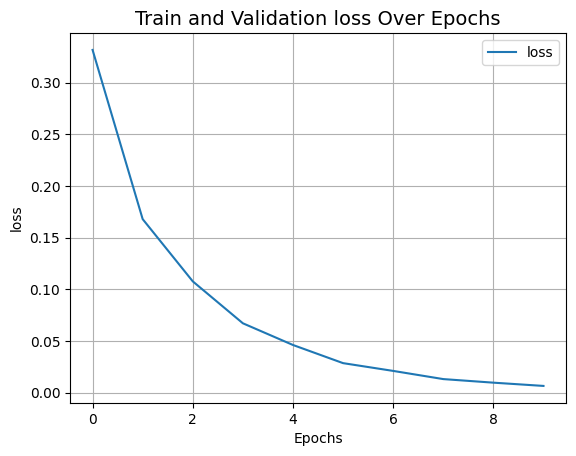

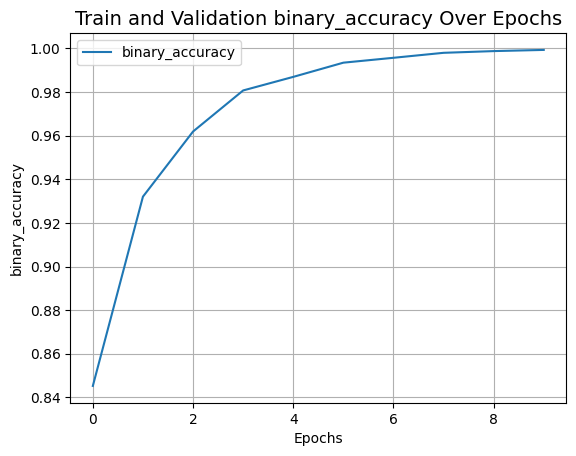

In [137]:
epochs = 10

shallow_mlp_model = make_model()
history = shallow_mlp_model.fit( train_dataset,  epochs=epochs)


def plot_result(item):
    plt.plot(history.history[item], label=item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()


plot_result("loss")
plot_result("binary_accuracy")


In [138]:
_, binary_acc = shallow_mlp_model.evaluate(test_dataset)
print(f"Categorical accuracy on the test set: {round(binary_acc * 100, 2)}%.")


31/31 [==============================] - 0s 3ms/step - loss: 0.0070 - binary_accuracy: 0.9991
Categorical accuracy on the test set: 99.91%.
